# 对比性测试

In [1]:
if !isdefined(Main, :JuNarsese)
    push!(LOAD_PATH, "../src") # 用于直接打开（..上一级目录）
    push!(LOAD_PATH, "../../JuNarsese/") # 用于直接打开（..上一级目录）
    push!(LOAD_PATH, "src") # 用于VSCode调试（项目根目录起）
    push!(LOAD_PATH, "../JuNarsese/") # 用于VSCode调试（项目根目录起）

    # 自动导入JuNarsese模块
    using JuNarsese
    using JuNarseseParsers
end

JuNarsese v1.1.3


## 测试集生成

宏の辅助：自动生成if-elseif-else表达式

In [2]:
"""
自动生成if-elseif-else表达式
使得其中的表达式只有在运行到时才会计算

参数：
- 元组：(条件, 内容)
"""
function generate_ifelseif_expressions(exprs::Vararg{Pair})
    return generate_ifelseif_expressions(nothing, exprs...)
end

"+默认情况"
function generate_ifelseif_expressions(default, exprs::Vararg{Pair})
    blk::Expr = Expr(:block)
    return generate_ifelseif_expressions!(blk, default, exprs...)
end

"""
基于已有的:block表达式，附带默认情况
"""
function generate_ifelseif_expressions!(parent::Expr, default, exprs::Vararg{Pair})

    current_args::Vector = parent.args
    is_first::Bool = true
    for expr_pair::Pair in exprs
        push!(
            current_args, 
            Expr(
                is_first ? begin
                    is_first = false
                    :if
                end : :elseif,
                expr_pair.first, 
                expr_pair.second
            )
        )
        current_args = current_args[end].args # 跳到if/elseif表达式的末尾
    end

    # 默认情况：增加else
    !isnothing(default) && push!(
        current_args, 
        default
    )

    return parent
end

"""
基于已有的:block表达式
"""
function generate_ifelseif_expressions!(parent::Expr, exprs::Vararg{Pair})
    generate_ifelseif_expressions!(parent, nothing, exprs...)
end

"""
宏の形式
注意：传入的每个Pair表达式都是`Expr(:call, :(=>), 前, 后)`的形式
"""
macro generate_ifelseif_expressions(default, exprs::Vararg{Expr})
    # 直接获取第二、第三个参数
    return generate_ifelseif_expressions(
        default,
        (
            expr.args[2] => expr.args[3]
            for expr in exprs
        )...
    ) |> esc
end

d = Dict(
    1 => 1, 2 => 2, 3 => 3
)

@show generate_ifelseif_expressions(0, d...)

@show r = rand(1:4)

# 最多睡3秒
@generate_ifelseif_expressions 4 (sleep(1);r==1) => 2 (sleep(1);r==2) => 3 (sleep(1);r==3) => 4

generate_ifelseif_expressions(0, d...) = quote
    if 2
        2
    elseif 3
        3
    elseif 1
        1
    else
        0
    end
end
r = rand(1:4) = 4


4

In [3]:
"""
宏的等价函数
用于自动
1. 构造随机数
2. 生成`if-elseif-else`表达式
"""
function rand_macro(exprs...)::Union{Symbol, Expr}

    # 预先计算表达式数量
    n = length(exprs)

    # 可能是封装到数组里面去了
    if n == 1
        exprs = exprs[1].args
        n = length(exprs)
    end

    # 只有一个⇒优化：直接返回
    if n == 1
        return exprs[1] # 可能是Symbol
    end
    # @assert n > 1 "随机选择至少需要两个备选结果"

    rand_variable::Symbol = Symbol(":rand_n:")

    # 构造代码块
    blk::Expr = Expr(
        :block,
        :(local $rand_variable = rand(1:$n))
    )

    return generate_ifelseif_expressions!(
        blk,
        (
            :($rand_variable == $i) => expr
            for (i, expr) in enumerate(exprs)
        )...
    )
end

"""
一个用于随机选择代码执行的宏
避免「在随机选择之前，预先计算出所有的备选结果」
"""
macro rand(exprs...)
    rand_macro(exprs...) |> esc
end

# 最多睡一秒
@rand sleep(0.5) sleep(0.75) sleep(1)

随机词项发生器

In [32]:
randstring(n) = *(rand(Char.(97:122), n)...)

randomName() = randstring(rand(1:10))

"随机产生一个原子词项"
function randomAtom(depth = 0, width = 0)
    type = @rand [
        Word
        IVar
        DVar
        QVar
        Operator
    ]
    type(randomName())
end

"随机产生一个陈述"
function randomStatement(depth = 5, width = 2)
    return @rand [
        randomTStatement(depth - 1, width)
        randomSStatement(depth - 1, width)
    ]
end

"""
随机产生一个面向词项的陈述
- 这里的陈述只能是「一等公民词项」
    - 适配OpenJunars
"""
function randomTStatement(depth = 5, width = 2)
    constructor = depth <= 0 ?
        randomAtom : randomFOTerm
    type = @rand [
        Inheriance
        Similarity
    ]
    type(constructor(depth - 1), constructor(depth - 1))
end

function randomSStatement(depth = 5, width = 2)
    constructor = depth <= 0 ?
        randomTStatement : randomStatement
    type = @rand [
        Implication
        Equivalence
    ]
    type(constructor(depth - 1), constructor(depth - 1))
end

function randomImage(depth = 5, width = 2)
    type = @rand [
        ExtImage,
        IntImage
    ]
    terms = [randomTerm(depth - 1,width) for _ in 1:rand(1:width)]
    relation_index::Integer = rand(1:(length(terms)+1))
    type(relation_index, terms...)
end

function randomTermSets(depth = 5, width = 2)
    type = @rand [
        TermProduct
        ExtSet
        IntSet
        ExtIntersection
        IntIntersection
    ]
    type((
        randomTerm(depth - 1,width)
        for _ in 1:rand(1:width)
    )...)
end


"随机产生一个复合词项"
function randomCompound(depth = 5, width = 5)
    return @rand [
        randomTermSet2s(depth - 1, width)
        randomTermSets(depth - 1, width)
        randomStatement(depth - 1, width)
        randomImage(depth - 1, width)
    ]
end

"迁移自OpenJunars：「一等公民词项」=原子+复合，而非陈述"
function randomFOTerm(depth = 5, width = 5)
    return @rand [
        randomAtom(depth - 1, width)
        randomCompound(depth - 1, width)
    ]
end

""
function randomTermSet2s(depth = 5, width = 2)
    type = @rand [
        ExtDifference
        IntDifference
    ]
    type(randomTerm(depth - 1), randomTerm(depth - 1))
end

""
function randomStatementSets(depth = 5, width = 2)
    type = @rand [
        Conjunction
        Disjunction
        ParConjunction
        SeqConjunction
    ]
    type(randomStatement(depth - 1), randomStatement(depth - 1))
end

#=
    IntDifference
=#

function randomTerm(depth=3, width=3)
    depth <= 0 ?
    randomAtom() : @rand [
        randomCompound(depth-1, width)
        # Negation(randomStatement(depth-1, width))
        # randomAtom()
    ]
end

randomTerm(5, 5)

<<<?xfbm <-> #vdc> ==> <$qaxpvvqge <-> #rcu>> <=> <^o --> $tgj>>

生成测试集

In [33]:
# 生成测试集
D = 5 # 嵌套深度
W = 5 # 项数广度
N = 100 # 词项数量

# 展示一个
@show randomTerm(D, W)

test_terms = [
    randomTerm(D, W)
    for _ in 1:N
]

randomTerm(D, W) = (\, _, (/, sbnahpxbe, ^ruhirivly, _, $nnwjrk, wzpsggef), <<#iqvqqxmln --> #sfqruv> <=> <^zdtbtekln <-> #fo>>, (/, ^ksxy, $ovl, #h, _, ^tntqem))


100-element Vector{AbstractCompound}:
 (&, <?buhiwv <-> $rfsatpmqt>, (&, drj, #x), (~, $mx, $ap), <<^zqjniucixz <-> $qyulfrtg> ==> <$txdcqyyqpg <-> $o>>, (/, _, nexkg, $dusmknal))
 (\, _, (\, _, ?oktfpluw), (~, ^oawdzvqzd, gvpaq))
 <<<msnnbvl <-> $zep> ==> <#lugde <-> #igznxd>> ==> <<$f --> ?iwf> <=> <vmrhvvqa <-> pt>>>
 (&, <<^htkvvkk --> kzpamyvym> ==> <jr <-> ^bnblj>>, <oxqg <-> ?zlekqa>)
 <pdal <-> (\, csejkaex, #mwmyxhnwir, ^unj, _)>
 <^uhynts <-> ?tktu>
 <<#wpsrrlcj <-> $ylwyu> <=> <#wqeg <-> $uztkbkq>>
 (&, (/, _, ^pivsyythct, ^ytosr), <<^vjcto <-> ehhvt> <=> <#fk --> ^ycjc>>)
 (-, (-, sngyap, $skzlkxeep), {^shrbz, $bw})
 (~, (\, $lihsmdzer, _, e, $feodbbi), (-, ?yfgwoismj, ?vcmswpcpg))
 ⋮
 (~, <kbus <-> ^qbelubpkwi>, (\, #sfae, parushy, d, _))
 <clwbu <-> #dkgyxzsixx>
 (\, _, (&, $jaydvvydea, #ibgk, sjz), <ynqwpx <-> #u>, (\, ^vlel, ?oiwxjwoubs, $vuxwrf, $loreljl, ^knrsijakl, _), (~, $osrlhrse, ?hksf), (*, $qjtxhvhwq, ?ux, ?afh, ?rogmlgsw, llpn))
 (-, (\, ^owjjivmfvq, ?lrxqen, 

In [34]:
test_strings = test_terms .|> string
@show test_strings

test_strings = ["(&, <?buhiwv <-> \$rfsatpmqt>, (&, drj, #x), (~, \$mx, \$ap), <<^zqjniucixz <-> \$qyulfrtg> ==> <\$txdcqyyqpg <-> \$o>>, (/, _, nexkg, \$dusmknal))", "(\\, _, (\\, _, ?oktfpluw), (~, ^oawdzvqzd, gvpaq))", "<<<msnnbvl <-> \$zep> ==> <#lugde <-> #igznxd>> ==> <<\$f --> ?iwf> <=> <vmrhvvqa <-> pt>>>", "(&, <<^htkvvkk --> kzpamyvym> ==> <jr <-> ^bnblj>>, <oxqg <-> ?zlekqa>)", "<pdal <-> (\\, csejkaex, #mwmyxhnwir, ^unj, _)>", "<^uhynts <-> ?tktu>", "<<#wpsrrlcj <-> \$ylwyu> <=> <#wqeg <-> \$uztkbkq>>", "(&, (/, _, ^pivsyythct, ^ytosr), <<^vjcto <-> ehhvt> <=> <#fk --> ^ycjc>>)", "(-, (-, sngyap, \$skzlkxeep), {^shrbz, \$bw})", "(~, (\\, \$lihsmdzer, _, e, \$feodbbi), (-, ?yfgwoismj, ?vcmswpcpg))", "<(*, ?psynyy, #kirlillzo, ^bzjompa) --> {#otpnigsk}>", "(/, _, (/, ?hrpymkd, ^hlmrhxzyy, _), (/, _, ?byubvchr, ^o, ^hchrfz, #bhlnzgcqy), (&, #i, #lvx, #wguskvjw), (~, #dt, \$o), (&, grhcs, \$cjhgt, #etdu, ^m))", "<<<^jqxqmdo --> ^rgv> <=> <x <-> #dzhetvgr>> ==> <^sj <-> xjfh>>",

100-element Vector{String}:
 "(&, <?buhiwv <-> \$rfsatpmqt>, (" ⋯ 78 bytes ⋯ "\$o>>, (/, _, nexkg, \$dusmknal))"
 "(\\, _, (\\, _, ?oktfpluw), (~, ^oawdzvqzd, gvpaq))"
 "<<<msnnbvl <-> \$zep> ==> <#lugd" ⋯ 27 bytes ⋯ "> ?iwf> <=> <vmrhvvqa <-> pt>>>"
 "(&, <<^htkvvkk --> kzpamyvym> ==> <jr <-> ^bnblj>>, <oxqg <-> ?zlekqa>)"
 "<pdal <-> (\\, csejkaex, #mwmyxhnwir, ^unj, _)>"
 "<^uhynts <-> ?tktu>"
 "<<#wpsrrlcj <-> \$ylwyu> <=> <#wqeg <-> \$uztkbkq>>"
 "(&, (/, _, ^pivsyythct, ^ytosr), <<^vjcto <-> ehhvt> <=> <#fk --> ^ycjc>>)"
 "(-, (-, sngyap, \$skzlkxeep), {^shrbz, \$bw})"
 "(~, (\\, \$lihsmdzer, _, e, \$feodbbi), (-, ?yfgwoismj, ?vcmswpcpg))"
 ⋮
 "(~, <kbus <-> ^qbelubpkwi>, (\\, #sfae, parushy, d, _))"
 "<clwbu <-> #dkgyxzsixx>"
 "(\\, _, (&, \$jaydvvydea, #ibgk, " ⋯ 119 bytes ⋯ ", ?ux, ?afh, ?rogmlgsw, llpn))"
 "(-, (\\, ^owjjivmfvq, ?lrxqen, _, m), (-, i, ?vwkxzf))"
 "(*, (\\, #tgvbptflsa, _, ^isgd, " ⋯ 75 bytes ⋯ "favnk, _), (-, ?blaophh, \$vaa))"
 "(\\, _, <\$dxajdc <-> ?x>, {\

## 评估函数

导入数据分析工具：DataFrames

In [35]:
using DataFrames

构造评估函数

In [36]:
d = DataFrame(
    string = Vector{String}(),
    parsed = Vector{Any}(),
    time = Vector{Float64}(),
    error = Vector{Union{Exception, Missing}}()
)

push!(
    d,
    (
        string = "1",#test_strings[i],
        parsed = "1",#parse(test_strings[i]),
        time = 0.0,
        error = missing
    )
)

Row,string,parsed,time,error
,String,Any,Float64,Exception?
1,1,1,0.0,missing


In [99]:
"""
构造一个测试解析器的函数，
输入解析器、测试集、测试次数，
输出解析结果、每次解析的耗时时长、总时长和总平均时长
"""
function testParser(parser, test_strings, n = 100)

    # datas
    datas::DataFrame = DataFrame(
        string = Vector{String}(),
        parsed = Vector{Union{Any, Missing}}(),
        time = Vector{Union{Float64, Missing}}(),
        error = Vector{Union{Exception, Missing}}()
    )

    # 重复n次解析，每次解析一批
    for _ in 1:n
        for term_string in test_strings
            try
                # 解析&计时
                parse_time = @elapsed (
                    parsed_term = parser(term_string)
                )
                # 存储数据
                push!(
                    datas,
                    (
                        string = term_string,
                        parsed = parsed_term,
                        time = parse_time,
                        error = missing
                    )
                )
            catch e
                # @error "已跳过解析错误的项，错误信息为：" term_string e
                # 记录错误
                push!(
                    datas,
                    (
                        string = term_string,
                        parsed = missing,
                        time = missing,
                        error = e
                    )
                )
            end
        end
    end
    
    # 根据errors汇报错误
    errors = filter(!ismissing, d.error)
    if length(errors) > 0
        @error "以下$(length(errors))项解析错误：" errors
    end

    # 返回结果
    return datas
end

testParser

试运行

In [100]:
# 测试字符串解析器
results = testParser(StringParser_ascii, test_strings)

Row,string,parsed,time,error
,String,Any,Float64?,Exception?
1,"(&, <?buhiwv <-> $rfsatpmqt>, (&, drj, #x), (~, $mx, $ap), <<^zqjniucixz <-> $qyulfrtg> ==> <$txdcqyyqpg <-> $o>>, (/, _, nexkg, $dusmknal))","(&, (/, _, nexkg, $dusmknal), (&, drj, #x), <<^zqjniucixz <-> $qyulfrtg> ==> <$txdcqyyqpg <-> $o>>, (~, $mx, $ap), <?buhiwv <-> $rfsatpmqt>)",0.0002873,missing
2,"(\\, _, (\\, _, ?oktfpluw), (~, ^oawdzvqzd, gvpaq))","(\\, _, (\\, _, ?oktfpluw), (~, ^oawdzvqzd, gvpaq))",0.0001086,missing
3,<<<msnnbvl <-> $zep> ==> <#lugde <-> #igznxd>> ==> <<$f --> ?iwf> <=> <vmrhvvqa <-> pt>>>,<<<msnnbvl <-> $zep> ==> <#lugde <-> #igznxd>> ==> <<$f --> ?iwf> <=> <vmrhvvqa <-> pt>>>,0.0001159,missing
4,"(&, <<^htkvvkk --> kzpamyvym> ==> <jr <-> ^bnblj>>, <oxqg <-> ?zlekqa>)","(&, <<^htkvvkk --> kzpamyvym> ==> <jr <-> ^bnblj>>, <oxqg <-> ?zlekqa>)",8.23e-5,missing
5,"<pdal <-> (\\, csejkaex, #mwmyxhnwir, ^unj, _)>","<pdal <-> (\\, csejkaex, #mwmyxhnwir, ^unj, _)>",3.87e-5,missing
6,<^uhynts <-> ?tktu>,<^uhynts <-> ?tktu>,1.38e-5,missing
7,<<#wpsrrlcj <-> $ylwyu> <=> <#wqeg <-> $uztkbkq>>,<<#wpsrrlcj <-> $ylwyu> <=> <#wqeg <-> $uztkbkq>>,3.95e-5,missing
8,"(&, (/, _, ^pivsyythct, ^ytosr), <<^vjcto <-> ehhvt> <=> <#fk --> ^ycjc>>)","(&, (/, _, ^pivsyythct, ^ytosr), <<^vjcto <-> ehhvt> <=> <#fk --> ^ycjc>>)",7.16e-5,missing
9,"(-, (-, sngyap, $skzlkxeep), {^shrbz, $bw})","(-, (-, sngyap, $skzlkxeep), {^shrbz, $bw})",5.56e-5,missing


In [101]:
# 导入OpenJunars
push!(LOAD_PATH, "../../../OpenJunars/")
import Junars

# 测试OpenJunars
parser = Junars.parse_term
parser("<A --> B>")

"<A-->B>"

In [102]:
@show test_strings[1]
test_strings[1] |> Junars.parse_term

"(&,(&,#x,drj),(/,_,nexkg,\$dusmknal),(~,\$mx,\$ap),<\$rfsatpmqt<->?buhiwv>,<<\$qyulfrtg<->^zqjniucixz>==><\$o<->\$txdcqyyqpg>>)"

In [103]:
testParser(Junars.parse_term, test_strings)

Row,string,parsed,time,error
,String,Any,Float64?,Exception?
1,"(&, <?buhiwv <-> $rfsatpmqt>, (&, drj, #x), (~, $mx, $ap), <<^zqjniucixz <-> $qyulfrtg> ==> <$txdcqyyqpg <-> $o>>, (/, _, nexkg, $dusmknal))","""(&,(&,#x,drj),(/,_,nexkg,\\$dusmknal),(~,\\$mx,\\$ap),<\\$rfsatpmqt<->?buhiwv>,<<\\$qyulfrtg<->^zqjniucixz>==><\\$o<->\\$txdcqyyqpg>>)""",0.0002992,missing
2,"(\\, _, (\\, _, ?oktfpluw), (~, ^oawdzvqzd, gvpaq))","""(\\\\,_,(\\\\,_,?oktfpluw),(~,^oawdzvqzd,gvpaq))""",2.58e-5,missing
3,<<<msnnbvl <-> $zep> ==> <#lugde <-> #igznxd>> ==> <<$f --> ?iwf> <=> <vmrhvvqa <-> pt>>>,"""<<<\\$zep<->msnnbvl>==><#igznxd<->#lugde>>==><<\\$f-->?iwf><=><pt<->vmrhvvqa>>>""",6.94e-5,missing
4,"(&, <<^htkvvkk --> kzpamyvym> ==> <jr <-> ^bnblj>>, <oxqg <-> ?zlekqa>)","""(&,<<^htkvvkk-->kzpamyvym>==><^bnblj<->jr>>,<?zlekqa<->oxqg>)""",3.68e-5,missing
5,"<pdal <-> (\\, csejkaex, #mwmyxhnwir, ^unj, _)>","""<(\\\\,csejkaex,#mwmyxhnwir,^unj,_)<->pdal>""",5.22e-5,missing
6,<^uhynts <-> ?tktu>,"""<?tktu<->^uhynts>""",4.2e-6,missing
7,<<#wpsrrlcj <-> $ylwyu> <=> <#wqeg <-> $uztkbkq>>,"""<<#wpsrrlcj<->\\$ylwyu><=><#wqeg<->\\$uztkbkq>>""",2.38e-5,missing
8,"(&, (/, _, ^pivsyythct, ^ytosr), <<^vjcto <-> ehhvt> <=> <#fk --> ^ycjc>>)","""(&,(/,_,^pivsyythct,^ytosr),<<#fk-->^ycjc><=><^vjcto<->ehhvt>>)""",5.6e-5,missing
9,"(-, (-, sngyap, $skzlkxeep), {^shrbz, $bw})","""(-,(-,sngyap,\\$skzlkxeep),{\\$bw,^shrbz})""",2.37e-5,missing


## 对比性评估开始

In [104]:
# 设立一个包括所有解析器(可调用对象)的数组，遍历这个数组用同样的测试集测试每一个解析器，将解析结果存储在“解析器 => 解析结果”的字典中，展示该字典
parser_list = [
    StringParser_ascii, 
    Junars.parse_term
]

results = Dict{Any, Any}()

N = 500
for parser in parser_list
    results[parser] = testParser(
        parser, 
        test_strings, 
        N
    )
end

results # Excessive output truncated after 951830 bytes.

Dict{Any, Any} with 2 entries:
  parse_term         => 50000×4 DataFrame…
  StringParser_ascii => 50000×4 DataFrame…

## 比对结果分析、展示

In [108]:
# 使用@show展示字典里面的每一个元素，展开展示里面的测试结果
# 打印结果
for result in results
    result.first, result.second
    for r in eachcol(result.second)
        if r isa Union{Array, Tuple, Dict} && length(r) > 100
            continue
        end
        println("$(result.first) => \n$r")
    end
end

In [106]:
using CairoMakie

In [123]:
parser_names = Dict(
    Junars.parse_term => "Junars",
    StringParser_ascii => "JuNarsese"
)

Dict{Any, String} with 2 entries:
  parse_term         => "Junars"
  StringParser_ascii => "JuNarsese"

In [132]:
# 使用CairoMakie打印其中的「解析时间线」
fig = Figure()
ax = Axis(fig[1, 1])
for (parser, result) in results
    xs = 1:length(result.time)
    ys = replace!(result.time, missing => 0)
    sl = scatterlines!(
        ax, xs, ys;
        label = parser_names[parser],
        # color = :black,
        linewidth = 0,
        markersize = 5,
    )
    @show sl[2]
    # 绘制均值一条线
    mean_ys = sum(ys) / length(ys)
    mean_ys = mean_ys * ones(length(ys))
    lines!(
        ax, xs, mean_ys; 
        # color = :black, 
        linewidth = 1
    )
    # xlabel!(ax, "序号")
    # ylabel!(ax, "每一批次的解析时间(秒)")
    # title!(ax, "每一批次的解析时间变化")
    # fig[1, 2] = Legend(fig, ax, string(parser))
end
axislegend("解析器类型"; position=:rt)
# xlims!(ax, 0, 0.005)
# ylims!(ax, 0, 1)
# xscale!(ax, log10)
# yscale!(ax, log10)
ax.yscale = log10
ax.ylom = log10
# xgrid!(ax)
# ygrid!(ax)

current_figure()

ErrorException: Found invalid y-limits (0.0f0, 0.0310802f0) for scale log10 which is defined on the interval 0.0 .. Inf (open)

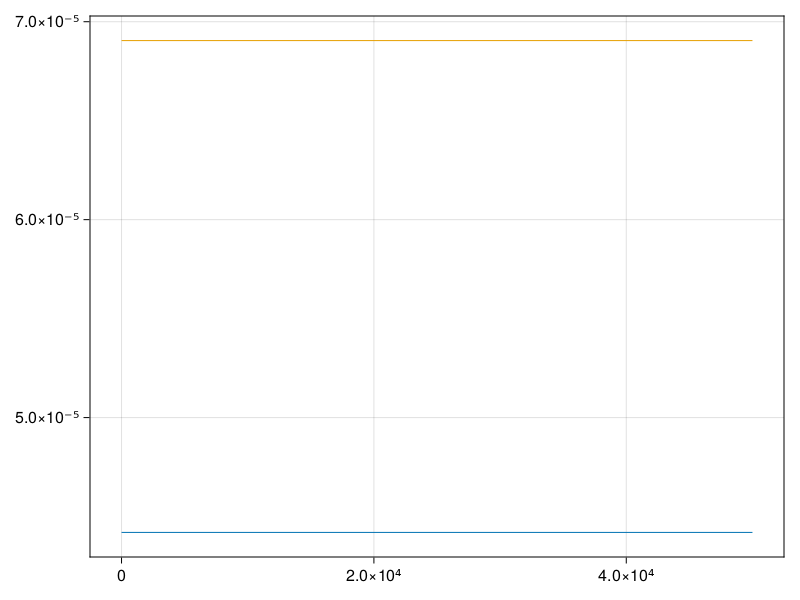

In [125]:
# 使用CairoMakie打印其中的「解析时间线」
fig = Figure()
ax = Axis(fig[1, 1])
for (parser, result) in results
    xs = 1:length(result.time)
    ys = replace!(result.time, missing => 0)
    mean_ys = sum(ys) / length(ys)
    mean_ys = mean_ys * ones(length(ys))
    lines!(
        ax, xs, mean_ys; 
        # color = :black, 
        linewidth = 1
    )
    # xlabel!(ax, "序号")
    # ylabel!(ax, "每一批次的解析时间(秒)")
    # title!(ax, "每一批次的解析时间变化")
    # fig[1, 2] = Legend(fig, ax, string(parser))
end
# axislegend("legend"; position=:rt)
# xlims!(ax, 0, 0.005)
# ylims!(ax, 0, 1)
# xscale!(ax, log10)
# yscale!(ax, log10)
# xgrid!(ax)
# ygrid!(ax)

current_figure()